# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab, build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/Users/louis/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /Users/louis/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /Users/louis/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

### Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

In [3]:
tokenizer = get_tokenizer("basic_english", language="en")
def yield_tokens(data_iter):
    for doc in data_iter:
        yield tokenizer(doc["text"])
vocabulary = build_vocab_from_iterator(yield_tokens(train_df), min_freq=1, specials=["<unk>", "<pad>"])
vocabulary.set_default_index(vocabulary["<unk>"])

In [4]:
pad_token = "<pad>"

## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

In [5]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(vocabulary.forward(tokenizer(text)))


In [6]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [7]:
ids = text_pipeline("Some text I am thinking about... ragafqfa")
print(ids)
for id in ids :
    print(vocabulary.lookup_token(id))

tensor([  56, 3167,   13,  244,  527,   50,    3,    3,    3,    0])
some
text
i
am
thinking
about
.
.
.
<unk>


In [8]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.
* **\[1 point\]** On which side should you pad and why?

In [9]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    num_batches = (len(X) - 1) // batch_size + 1

    for i in range(num_batches) :
        starting_index = i * batch_size
        ending_index = min((i + 1) * batch_size, len(X))
        batch_X = X[starting_index:ending_index]
        batch_Y = y[starting_index:ending_index]
        max_len = 0
        for line in batch_X :
            max_len = max(max_len, len(line))
        for j in range(len(batch_X)) :
            len_pad = max_len - len(batch_X[j])
            if len_pad > 0:
                batch_X[j] = torch.cat((torch.full((len_pad,), pad_id), batch_X[j]), 0)
        yield torch.stack(batch_X), torch.tensor(batch_Y)

Le pad devrait se trouver à gauche des tokens, puisque cela permet d'obtenir de meilleurs résultats sur l'accuracy.

In [10]:
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember an RNN has 3 matrices and an embedding layer (see course slide 61).
* The embedding layer turns a one-hot vectors into dense vectors.
* The first matrix (W) connects the embedding to the hidden layer.
  * `embedding_size -> hidden_size`
* The second matrix (U) connect the previous hidden layer to the current one.
  * `hidden_size -> hidden_size`
* These to vectors are added and go through an activation function (e.g. $h_t = tanh(Wx_i+Uh_{t-1})$).
* The last matrix (V) connects the hidden layer to the hidden layer to the output.
  * `hidden_size -> 1`
* Donc forget to add an `init_hidden` function which initialize the first hidden layer to 0.

In [11]:
class RNN(nn.Module):
    def __init__(self,vocabulary_size,embedding_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocabulary_size, embedding_dim = embedding_size)
        self.W = nn.Linear(in_features=embedding_size, out_features=hidden_size)
        self.U = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.V = nn.Linear(in_features=hidden_size, out_features=1)
        self.tanh = nn.Tanh()
        self.hidden_size = hidden_size

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

    def forward(self,input):
        h = self.init_hidden(input.shape[0])
        for i in range(input.shape[1]):
            somme = self.W(self.embedding(input[:,i])) + self.U(h)
            h = self.tanh(somme)
        output  = self.V(h)
        return output.squeeze()

## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
from copy import deepcopy

n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

nb_epochs = 15
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):
    # training
    model.train()
    train_loss = 0.0
    # training loop
    i=0
    for batch_X, batch_Y in train_gen():
        optimizer.zero_grad()
        logits = model(batch_X.to(device))
        loss = criterion(logits, batch_Y.to(device).float())#to device
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        i += 1
    train_losses.append(train_loss / len(X_train))
    # validation
    model.eval()
    valid_loss = 0.0
    # validation loop
    with torch.no_grad():
        for batch_X, batch_Y in valid_gen():
            logits = model(batch_X.to(device))
            loss = criterion(logits, batch_Y.to(device).float())
            valid_loss += loss.item()
    valid_losses.append(valid_loss / len(X_valid))
    if (valid_losses[-1] < best_validation_loss) :
        best_validation_loss = valid_losses[-1]
        best_model = deepcopy(model)

print(best_validation_loss)
print(train_losses)
print(valid_losses)

  0%|          | 0/15 [00:00<?, ?it/s]

0.01536628286242485
[0.021073264029622077, 0.01924488596022129, 0.01793938842266798, 0.017363522213697434, 0.015920464139431715, 0.01468221689760685, 0.014250953401625157, 0.012847928455471993, 0.01221010528318584, 0.011839097390323877, 0.01112118105813861, 0.01017914912737906, 0.010467334476672113, 0.009146820383891464, 0.00845837153941393]
[0.02015995899438858, 0.018760973691940307, 0.018068841415643692, 0.0171596628010273, 0.01780647663474083, 0.01584417712688446, 0.016929049277305604, 0.016281000167131424, 0.01762328229546547, 0.015691918927431107, 0.0157859758079052, 0.02615843890309334, 0.01536628286242485, 0.01648359698057175, 0.017221107080578803]


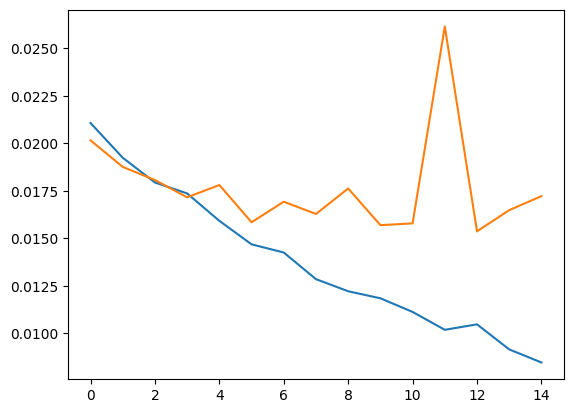

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(valid_losses)

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

In [15]:
def accuracy_computing(generator,X):
    model.eval()
    accuracy = 0
    with torch.no_grad():
        for batch_X, batch_Y in generator():
            logits = model(batch_X).squeeze()
            predictions = (logits > 0.5)
            accuracy += (predictions.int() == batch_Y).int().sum().item()
    accuracy /= len(X)
    return accuracy

In [16]:
train_accuracy = accuracy_computing(train_gen, X_train)

In [17]:
train_accuracy

0.883

In [18]:
valid_accuracy = accuracy_computing(valid_gen, X_valid)
valid_accuracy

0.7998

In [19]:
test_accuracy = accuracy_computing(test_gen, X_test)
test_accuracy

0.79384